In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from utils import *
from sklearn.linear_model import LinearRegression

In [2]:
project = "BRCA"

In [3]:
ik = 4
il_list = [0,1,2,3,4]
for i,il in enumerate(il_list): 
    preds = np.load("220Nov21BRCA_nonrot_ik%s_il%s/preds.npy"%(ik,il))
    
    if i == 0:
        labels = np.load("220Nov21BRCA_nonrot_ik%s_il%s/labels.npy"%(ik,il))
        print(preds.shape, labels.shape)

        preds_all = np.zeros((len(il_list), preds.shape[0], preds.shape[1]))
        
    preds_all[i,:,:] = preds

(206, 22884) (206, 22884)


In [4]:
preds_all.shape

(5, 206, 22884)

In [5]:
preds_mean = preds_all.mean(axis=0)
preds_mean.shape

(206, 22884)

In [6]:
coefs = compute_coefs(labels, preds_mean)
sum(coefs >= 0.4),sum(coefs >= 0.5),sum(coefs >= 0.6), sum(coefs >= 0.65)

(2289, 514, 24, 1)

In [7]:
i0 = np.argsort(coefs)[::-1]
print(i0[:20])
print(coefs[i0[:20]])

[ 4360 15884 14880 15653 12594  2480   256 12873  2107 11987 10651 12790
 14691 15076 13247  6903 12832 13545  2444  4218]
[0.65106217 0.64526409 0.63825525 0.63088188 0.62894144 0.62526581
 0.6243329  0.61728754 0.61670871 0.61655247 0.61561759 0.61558048
 0.60976144 0.60740785 0.60737711 0.60458825 0.60415633 0.60373756
 0.6029045  0.60276779]


In [8]:
np.save("labels.npy", labels)
np.save("preds_mean.npy", preds_mean)

In [9]:
genes = np.loadtxt("../15select_genes/%s_gene_active90_mediansorted_names.txt"%project, dtype="str")
gene_names = genes[:,5]
genes = genes[:,0]

In [10]:
np.savetxt("%s_R.txt"%project, np.array((genes, gene_names, coefs)).T, fmt="%s %s %s")
np.savetxt("%s_R_sorted.txt"%project, np.array((genes[i0], gene_names[i0], coefs[i0])).T, fmt="%s %s %s")

### Plot

In [11]:
## sort before plot
coefs = coefs[i0]
gene_names = gene_names[i0]
labels = labels[:,i0]
preds = preds_mean[:,i0]

In [14]:
## best predictable genes
slope = np.zeros(10)
intercept = np.zeros(10)
for i in range(10):
    #reg = LinearRegression(fit_intercept=False).fit(labels[:,i].reshape(-1,1), preds[:,i].reshape(-1,1))
    reg = LinearRegression(fit_intercept=True).fit(labels[:,i].reshape(-1,1), preds[:,i].reshape(-1,1))
    slope[i] = reg.coef_[0]
    intercept[i] = reg.intercept_[0]
    
    
print(slope)
print(intercept)

[0.44603787 0.37459282 0.34851697 0.36044939 0.36725267 0.37837116
 0.40291124 0.33402423 0.37545819 0.33801546]
[2.91264874 2.45193389 2.65968842 2.55631006 2.77135418 3.45493666
 3.79894198 2.93759475 3.49472816 3.00217781]


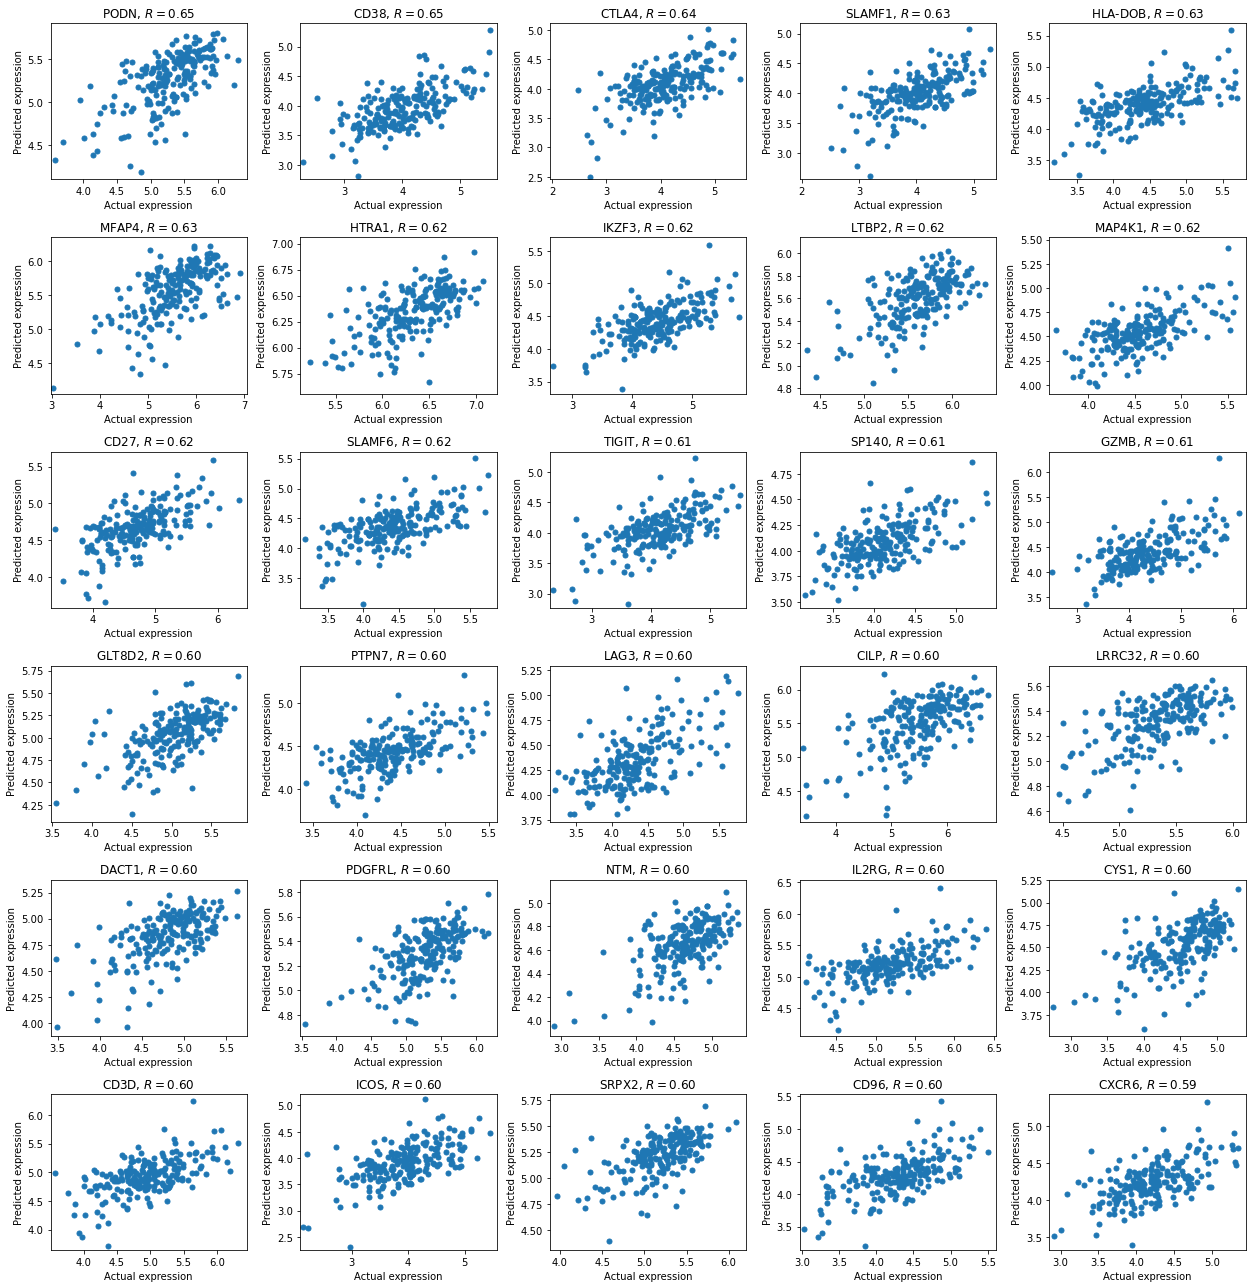

In [19]:
##----------------
nx,ny = 5,6
fig, ax = plt.subplots(ny,nx,figsize=(nx*3.5,ny*3))

markers = ["^", "v", "+", "*", "o"]
colors = ['r','g','b','c','m', 'y', 'k']

ij = 0
for j in range(ny):
    for i in range(nx):
        ## test set:
        
        label = labels[:,ij]
        pred = preds[:,ij]
        
        #xy_min = min(min(label_all),min(pred_all))
        #xy_max = max(max(label_all),max(pred_all))
                
        #ax[j,i].plot([xy_min, xy_max], [xy_min, xy_max],"--")

        ax[j,i].set_xlabel("Actual expression")
        ax[j,i].set_ylabel("Predicted expression")
        
        xmin = max(min(label),2)*0.98
        xmax = max(label)*1.02
        
        ymin = max(min(pred),2)*0.98
        ymax = max(pred)*1.02
        
        ax[j,i].set_xlim([xmin,xmax])
        ax[j,i].set_ylim([ymin,ymax])
        
        #slope, intercept = np.polyfit(label, pred,1)
        #x = np.linspace(xmin,xmax,20)
        #y = slope[ij]*x + intercept[ij]
        #y = x
        #for ik in range(nk_folds):
        #    label = labels[ik][:,i0[ij]]
        #    pred = preds[ik][:,i0[ij]]
            
        #    ax[j,i].scatter(label, pred, marker=markers[ik], color=colors[ik])
            
        ax[j,i].plot(label, pred, "o", markersize="5")
        #ax[j,i].plot(x,y, "--")
        ax[j,i].set_title("%s, $R=%3.2f$"%(gene_names[ij],coefs[ij]))

        
        #ax[j,i].set_title("$R=%3.2f \pm %3.2f$"%(coef_mean[i0[ij]], coef_std[i0[ij]]))
        
        ij += 1
    #ax[0,0].legend()

plt.tight_layout(h_pad=1, w_pad= 1.0)
plt.savefig('best_preds_ik%s_top30.pdf'%ik, format='pdf', dpi=50)